## Yolo 적용을 위한 파이썬과 딥러닝 이해
# cifar-10 이미지셋 CNN 적용

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### cifar-10 데이터 불러오기
- http://www.cs.toronto.edu/~kriz/cifar.html
- cifar-10-python.tar.gz

In [2]:
import pickle

X_train = None
y_train = []

for i in range(1,6):
    f = open('../프로그래밍/keras_new/cifar10/data_batch_'+str(i), 'rb')
    dict = pickle.load(f, encoding='bytes') # [b'batch_label', b'labels', b'data', b'filenames']
    f.close()
    
    X_now = dict[b'data']
    if i==1:
        X_train = X_now
    else:
        X_train = np.r_[X_train, X_now]
        
    y_train += dict[b'labels']

In [3]:
X_train.shape, len(y_train)

((50000, 3072), 50000)

- 3072 개의 값은 R채널, G채널, B채널 순으로 되어 있다. 즉 (3,32,32) 형태이다.
- np.moveaxis() 를 이용해 1번 축을 마지막으로 보내야 한다.

In [4]:
X_train = np.moveaxis(X_train.reshape(-1,3,32,32), 1, -1)

Text(0.5,1,'6')

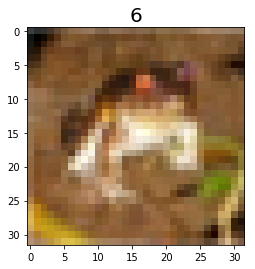

In [5]:
plt.imshow(X_train[0])
plt.title(y_train[0], fontsize=20)

In [10]:
X_train[0].dtype, X_train[0].max()

(dtype('uint8'), 255)

In [8]:
y_train[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

### 테스트 데이터 불러오기

In [11]:
import pickle

f = open('../프로그래밍/keras_new/cifar10/test_batch', 'rb')
dict = pickle.load(f, encoding='bytes') # [b'batch_label', b'labels', b'data', b'filenames']
f.close()

X_test = dict[b'data']
y_test = dict[b'labels']

In [12]:
X_test.shape, len(y_test)

((10000, 3072), 10000)

In [13]:
X_test = np.moveaxis(X_test.reshape(-1,3,32,32), 1, -1)

### 사진 레이블 알아내기

In [14]:
f = open('../프로그래밍/keras_new/cifar10/batches.meta', 'rb')
dict = pickle.load(f, encoding='bytes') # [b'batch_label', b'labels', b'data', b'filenames']
f.close()

dict.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [16]:
dict[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [18]:
labels = [b.decode() for b in dict[b'label_names']]
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### 데이터 정리
- X_train, y_train
- X_test, y_test
- labels

In [20]:
from keras.utils import np_utils

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
X_train = X_train/255.

In [21]:
y_train = np_utils.to_categorical(y_train, 10)

In [22]:
X_test = X_test/255.

In [23]:
y_test = np_utils.to_categorical(y_test, 10)

In [24]:
labels = np.array(labels)

- 데이터 확인

In [25]:
X_train.shape, X_train[0].max()

((50000, 32, 32, 3), 1.0)

In [26]:
y_train.shape

(50000, 10)

In [27]:
X_test.shape, X_test[0].max()

((10000, 32, 32, 3), 1.0)

In [28]:
y_test.shape

(10000, 10)

In [29]:
labels.shape

(10,)

### CNN 개념

<img src='https://community.arm.com/cfs-file/__key/communityserver-blogs-components-weblogfiles/00-00-00-21-42/Neural-Network-Model-Definition.jpg' />
(출처: https://community.arm.com/developer/ip-products/processors/b/processors-ip-blog/posts/deploying-convolutional-neural-network-on-cortex-m-with-cmsis-nn?CommentSortBy=CreatedDate&CommentSortOrder=Descending )<br>

<img src='cifar-10.jpg' />
(출처: https://arxiv.org/pdf/1611.04905.pdf )

- 입력이미지 -> Convolution -> MaxPooling -> Convolution -> MaxPooling -> ... -> 완전연결층 -> 출력

#### 첫번째 Convolution
- cifar-10 이미지는 칼러이다. 그러므로 채널은 3개!
- 흑백 이미지는 3X3 필터를 적용하지만, 칼러 이미지에는 3X3X3 필터를 적용한다. (마지막의 3은 채널 갯수를 나타낸다. 필터당 인자는 27개 이다.)
- 32X32X3 칼러이미지 => Convolution(필터) 적용, 필터는 3X3X3 => 30X30 이미지
- 필터를 32개 적용하면 => 30X30X32 이미지
> - Convolution 을 적용할 때, 원래 이미지 크기를 유지하도록 하는 옵션이 있다. 이렇게 하는 경우
> - 32X32X3 => 32X32X32

#### 첫번째 MaxPooling
- Convolution 층에서 30X30X32 이미지가 넘어온다. (채널이 32임)
- 2X2 MaxPooling 을 적용하면 사이즈가 반으로 줄어든다.
- 출력은 15X15X32

#### 뒷부분 완전연결층
- Convolution 과 MaxPooling 이 끝나면, 데이터를 1차원 형태로 풀어준다. (Flatten)
- 그 뒷부분은 앞에서 적용했던 것 처럼, Dense 층을 연결해 주면 된다.

### Keras 적용

In [34]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

In [38]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 4,200,842
Trainable params: 4,200,842
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.fit(X_train, y_train, epochs=2, batch_size=128, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 446s 11ms/step - loss: 2.1160 - acc: 0.2529 - val_loss: 1.9947 - val_acc: 0.2927
Epoch 2/2
40000/40000 [==============================] - 413s 10ms/step - loss: 1.8888 - acc: 0.3402 - val_loss: 1.9564 - val_acc: 0.2859


### Dropout 추가
- Dropout 은 고의적으로 중간 단계의 출력값 들을 누락시키는 것이다.
- 이렇게 하면 모델이 좀 더 예외상황에 견딜 수 있게 하여, 새로운 데이터에 대한 예측 능력을 키울 수 있다고 알려져 있다.

In [41]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total para

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.fit(X_train, y_train, epochs=2, batch_size=128, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 565s 14ms/step - loss: 2.1445 - acc: 0.2131 - val_loss: 1.9825 - val_acc: 0.3061
Epoch 2/2
40000/40000 [==============================] - 492s 12ms/step - loss: 1.9498 - acc: 0.3001 - val_loss: 1.8544 - val_acc: 0.3539
